In [1]:
import pandas as pd
import sentencepiece as spm
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
df = pd.read_csv('./data/diffused_sonnets_2.csv')

df['Variation Text'] = df['Variation Text'].str.replace('\n', ' <LINE> ')

df.head()

,Sonnet Number,Variation Number,Variation Text
0,1,1,"Desire for growth in loveliest of beings, <LIN..."
1,1,2,"In the fairest of beings, we crave increase, <..."
2,1,3,"For fairest beings, we yearn for more to grace..."
3,2,1,As forty winters carve their icy lines on your...
4,2,2,When winter's hand has etched its stories on y...


In [4]:
# 1. Prepare the training data for SentencePiece: join all sonnets with newlines
combined_text = '\n'.join(df['Variation Text'].tolist())

# 2. Write combined text to a temporary file (SentencePiece expects a file input for training)
with open('./data/sonnets_train.txt', 'w', encoding='utf-8') as f:
    f.write(combined_text)

# 3. Train SentencePiece tokenizer from the file
spm.SentencePieceTrainer.train(
    input='./data/sonnets_train.txt',
    model_prefix='./model/my_tokenizer',
    vocab_size=4000, 
    user_defined_symbols=['<LINE>', '<PAD>']
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/sonnets_train.txt
  input_format: 
  model_prefix: ./model/my_tokenizer
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <LINE>
  user_defined_symbols: <PAD>
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece

In [4]:
# 4. Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load('./model/my_tokenizer.model')

# 5. Tokenize each sonnet in the DataFrame
def tokenize_sonnet(text):
    return sp.encode_as_ids(text)

df['tokenized_sonnet'] = df['Variation Text'].apply(tokenize_sonnet)

# Example: print tokenized pieces for the first sonnet
print(df.loc[0, 'tokenized_sonnet'])

[1989, 30, 3528, 12, 2144, 104, 15, 1489, 6, 5, 3, 45, 239, 49, 9, 7, 236, 50, 1091, 20, 201, 6, 5, 3, 101, 21, 3718, 1284, 381, 6, 244, 76, 76, 2732, 6, 5, 3, 25, 639, 15, 2003, 16, 3482, 8, 5, 3, 61, 18, 6, 699, 16, 13, 60, 130, 145, 6, 5, 3, 64, 3015, 13, 92, 9, 7, 257, 35, 143, 79, 1434, 1892, 6, 5, 3, 2540, 20, 863, 12, 21, 610, 15, 953, 9, 7, 1998, 6, 5, 3, 105, 1992, 2635, 13, 60, 143, 6, 262, 182, 246, 8, 5, 3, 146, 6, 80, 10, 227, 9, 7, 216, 517, 328, 2139, 290, 6, 5, 3, 19, 31, 3033, 20, 83, 15, 451, 12, 62, 43, 504, 6, 5, 3, 24, 13, 60, 1084, 6, 214, 13, 152, 6, 5, 3, 19, 1705, 54, 977, 6, 158, 707, 974, 7, 3432, 8, 5, 3, 474, 67, 1095, 51, 10, 119, 6, 71, 46, 1894, 706, 757, 608, 6, 5, 3, 229, 230, 612, 87, 9, 7, 5, 2963, 6, 32, 417, 17, 99, 8, 5, 3, 5, 3]


In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.nonlinearity = nn.ReLU()

        # Initialize weights to identity and biases to zero
        nn.init.eye_(self.fc1.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.eye_(self.fc2.weight)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        residual = x
        x = self.nonlinearity(self.fc1(x))
        x = self.fc2(x)
        x += residual  # Add the residual connection
        return x

class ClassifierWithMHAPositionEncoding(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim
        )
        self.position_embedding = nn.Embedding(
            num_embeddings=seq_len,  # Assuming max sequence length of 100
            embedding_dim=embedding_dim
        )
        self.mhe = nn.MultiheadAttention(
            embed_dim=embedding_dim,
            num_heads=1,
            batch_first=True
        )
        self.r1 = ResidualBlock(embedding_dim)
        self.clf = nn.Linear(embedding_dim, vocab_size)  # Changed to output vocab size
        
    def forward(self, x):
        # Positional encoding for the sequence
        pos_enc = self.position_embedding(torch.arange(x.size(1), device=x.device))  # make sure to use the same device
        pos_enc = pos_enc.unsqueeze(0).repeat(x.size(0), 1, 1)  # shape (batch_size, seq_len, embedding_dim)
        
        # Embedding of the input tokens
        x_embeddings = self.embedding(x)
        x = x_embeddings + pos_enc  # Add positional encoding to the embeddings
        
        # Multi-head attention
        x_ = self.mhe(x, x, x)[0]  # (batch_size, seq_len, embedding_dim)
        
        # Residual connection
        x = x_ + x
        
        # Residual block for transformation
        x = self.r1(x)
        
        # Global average pooling over the sequence (optional, depending on your task)
        # x = torch.mean(x, dim=1)  # Uncomment if using classification
        
        # Output layer that predicts next token in sequence (vocab_size logits)
        output = self.clf(x)  # shape (batch_size, seq_len, vocab_size)
        
        return output


In [6]:
def pad_tokenized_sonnets(tokenized_sonnets, pad_id=-1, max_len=256):

    # Truncate each token list to max_len, then convert to tensor
    token_tensors = [torch.tensor(tokens[:max_len]) for tokens in tokenized_sonnets]
    
    # Pad sequences to the max length in the batch (≤ max_len)
    padded_tensor = pad_sequence(token_tensors, batch_first=True, padding_value=pad_id)
    
    # If padding length is less than max_len, pad extra manually
    if padded_tensor.size(1) < max_len:
        pad_size = max_len - padded_tensor.size(1)
        pad_tensor = torch.zeros((padded_tensor.size(0), pad_size), dtype=padded_tensor.dtype)
        padded_tensor = torch.cat([padded_tensor, pad_tensor], dim=1)
    
    return padded_tensor

# Pad the tokenized sonnets
padded_sonnets = pad_tokenized_sonnets(df['tokenized_sonnet'].tolist(), pad_id=sp.piece_to_id('<PAD>'))

# Example: print the shape of the padded tensor
print(padded_sonnets.shape)  # Should be (batch_size, max_seq_len)

torch.Size([460, 256])


In [7]:
# Prepare input X and target y:
# X: tokenized sonnets padded to (batch_size, 256)
X = padded_sonnets  # torch.LongTensor

# y: X shifted left by 1 (next token prediction), pad last token with 0 or ignore_index
y = torch.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = sp.pad_id()  # or any padding token id to ignore last token prediction

In [8]:
X, y

(tensor([[1989,   30, 3528,  ...,    0,    0,    0],
         [  24,   10,  210,  ...,    0,    0,    0],
         [  42,  210,  104,  ...,    0,    0,    0],
         ...,
         [  24,  335,  753,  ...,    0,    0,    0],
         [  24,  186,    5,  ...,    0,    0,    0],
         [  24, 2270,  240,  ...,    0,    0,    0]]),
 tensor([[  30, 3528,   12,  ...,    0,    0,   -1],
         [  10,  210,  104,  ...,    0,    0,   -1],
         [ 210,  104, 1489,  ...,    0,    0,   -1],
         ...,
         [ 335,  753,    6,  ...,    0,    0,   -1],
         [ 186,    5,  491,  ...,    0,    0,   -1],
         [2270,  240,    6,  ...,    0,    0,   -1]]))

In [9]:
# Create your dataset from the padded tokens and labels
dataset = TensorDataset(X, y)

# Create a DataLoader with a batch size (adjust batch size to fit your GPU)
batch_size = 16  # Adjust based on GPU memory
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [10]:
def train_one_epoch(model, optimizer, data_loader):
    model.train()
    optimizer.zero_grad()
    
    # Loop over batches in data_loader
    total_loss = 0.0
    for x_batch, y_batch in data_loader:
        # Move the batch to the correct device (GPU/CPU)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        output = model(x_batch)  # output shape: (batch_size, seq_len, vocab_size)

        # Flatten output and target tensors
        output = output.view(-1, output.size(-1))  # Flatten to (batch_size * seq_len, vocab_size)
        y_batch = y_batch.view(-1)  # Flatten to (batch_size * seq_len)

        # Calculate loss
        loss = F.cross_entropy(output, y_batch, ignore_index=sp.pad_id())  # Use padding token if needed
        
        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()
        
        # Clear GPU memory (optional, but useful for large batches)
        torch.cuda.empty_cache()

        # Add to total loss for the epoch
        total_loss += loss.item()

    return total_loss / len(data_loader)

In [15]:
model = ClassifierWithMHAPositionEncoding(vocab_size=4000, seq_len=256, embedding_dim=128).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

In [16]:
# Initialize early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_loss = float('inf')
epochs_without_improvement = 0
losses = []

for epoch in tqdm(range(1000)):
    loss = train_one_epoch(model, optimizer, train_loader)

    losses.append(loss)
    
    # Track loss for early stopping
    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # If no improvement after 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to no improvement.")
        break
    
    # Optionally, you can save a checkpoint after each epoch or after improvements
    # You could save a checkpoint here to resume later if something goes wrong
    if epoch % 10 == 0:  # Save a checkpoint every 10 epochs, for example
        torch.save(model.state_dict(), f"./model/model_checkpoint_epoch_{epoch}.pth")


 10%|█         | 100/1000 [00:30<04:37,  3.25it/s]

Early stopping at epoch 100 due to no improvement.


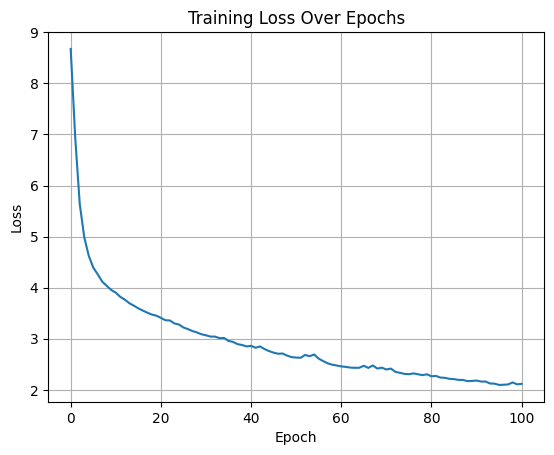

In [17]:
# Graph the losses per epoch
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()

In [19]:
def generate_sonnet(model, tokenizer, start_sequence, max_length=256, device='cuda'):
    model.eval()
    generated = tokenizer.encode(start_sequence)  # encode starting text
    generated = torch.tensor(generated, device=device).unsqueeze(0)  # shape (1, seq_len)

    for _ in range(max_length - generated.size(1)):
        outputs = model(generated)  # shape: (1, seq_len, vocab_size)
        next_token_logits = outputs[0, -1, :]  # last token logits
        
        # Greedy decoding: pick token with highest probability
        next_token_id = torch.argmax(next_token_logits).unsqueeze(0).unsqueeze(0)
        
        # Append to generated tokens
        generated = torch.cat([generated, next_token_id], dim=1)
        
        # Optional: stop if EOS token generated (if you have one)
        # if next_token_id.item() == tokenizer.eos_token_id:
        #     break
    
    # Decode tokens back to text
    generated_text = tokenizer.decode(generated[0].tolist())
    return generated_text


In [20]:
model.eval()

start_text = "Shall I compare thee to a summer's day"  # or any prompt you want
generated_sonnet = generate_sonnet(model, sp, start_text, max_length=256, device='cuda')
print(generated_sonnet)

Shall I compare thee to a summer's day's grip thought gone by yours, actions own's chains own di, , s, s , s, s, ent's sweetest. s, , ent, in itss, fs s, burnings, s, ents of love's, , s, s, ents, in the heart, sy, in yours, and my heart's, in the heart, in yours embrace, in my heart, to be trues allure, in yoursonate, s s, to be, s,, s, in yours, in your beauty, in my eyes,, in the flame, in yours, in my heart, to be true, , to yours, 's.d,, , 's.s. , being, y,, in this , , the depthss, and heart, in my heart, d, in my heart,  , 's shadow,, s rebirth me ⁇  ⁇  ⁇  ⁇  ⁇  ⁇  ⁇ 


In [36]:
def top_p_filtering(logits, top_p=0.9, filter_value=-float('Inf')):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    # Remove tokens with cumulative probability above threshold
    sorted_indices_to_remove = cumulative_probs > top_p
    # Shift the indices to keep at least one token
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0

    indices_to_remove = sorted_indices[sorted_indices_to_remove]
    logits[indices_to_remove] = filter_value
    return logits

def generate_sonnet_sampling(model, sp, start_sequence, max_length=256, device='cuda', top_k=50):
    model.eval()
    generated = sp.encode_as_ids(start_sequence)
    generated = torch.tensor(generated, device=device).unsqueeze(0)

    for _ in range(max_length - generated.size(1)):
        outputs = model(generated)
        next_token_logits = outputs[0, -1, :]

        # Use this in your generation loop before sampling
        logits = top_p_filtering(next_token_logits, top_p=0.9)
        probs = F.softmax(logits, dim=-1)
        next_token_id = torch.multinomial(probs, num_samples=1).unsqueeze(0)

        generated = torch.cat([generated, next_token_id], dim=1)

        # Optional: break on EOS token if you have one

    return sp.decode_ids(generated[0].tolist())


def clean_generated_text(text, pad_token='<PAD>'):
    text = text.split(pad_token)[0].strip()
    text = text.replace('<LINE>', '\n').replace('<PAD>', '').strip()
    return text

In [28]:
model.eval()

start_text = "Shall I compare thee to a summer's day"  # or any prompt you want
generated_sonnet = generate_sonnet_sampling(model, sp, start_text, max_length=256, device='cuda')

parsed = clean_generated_text(generated_sonnet, pad_token='<PAD>')
print(parsed)

Shall I compare thee to a summer's day my heart become oppress way bloom willful your nimble are' pains that gives way, cool praises of me, what was fleeting race. alent Time my heart sway. no longer wish's relentless rise swaye, invest, when every inclination in time unyielding?s rich blazety dy, lines, my strife and blunders on sea, strife, pain in prospers,, a soothings me, my trace and own dar igno page adorned another, muse'll endure, power the one and I acceptt me to leavety halt, bitter remor their, must made your add.'s your secret the current, my sighs, in holding backed: love. touch, though whisper, her longing my own part, man., I'll oppose. life.s a despair, must life:ing souls. my time. affection.


# **A Larger Model**

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TransformerBlock(nn.Module):
    def __init__(self, embedding_dim, num_heads, dropout=0.1):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim=embedding_dim, num_heads=num_heads, batch_first=True)
        self.norm1 = nn.LayerNorm(embedding_dim)
        self.dropout1 = nn.Dropout(dropout)
        
        self.ff = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.GELU(),
            nn.Linear(embedding_dim * 4, embedding_dim),
        )
        self.norm2 = nn.LayerNorm(embedding_dim)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x):
        # Multi-head attention with residual & layernorm
        attn_output, _ = self.mha(x, x, x)
        x = self.norm1(x + self.dropout1(attn_output))
        
        # Feed-forward with residual & layernorm
        ff_output = self.ff(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x


class LargerTransformerModel(nn.Module):
    def __init__(self, vocab_size, seq_len, embedding_dim=256, num_heads=8, num_layers=6, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Embedding(seq_len, embedding_dim)
        
        self.layers = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, dropout) for _ in range(num_layers)
        ])
        
        self.ln_f = nn.LayerNorm(embedding_dim)
        self.head = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, x):
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        
        x = self.embedding(x) + self.position_embedding(positions)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.ln_f(x)
        logits = self.head(x)
        return logits

In [30]:
model2 = LargerTransformerModel(
    vocab_size=4000, 
    seq_len=256, 
    embedding_dim=256, 
    num_heads=8, 
    num_layers=6, 
    dropout=0.1
).to(device)

optimizer2 = Adam(model2.parameters(), lr=1e-4)

In [31]:
# Initialize early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_loss = float('inf')
epochs_without_improvement = 0
losses = []

for epoch in tqdm(range(1000)):
    loss = train_one_epoch(model2, optimizer2, train_loader)

    losses.append(loss)
    
    # Track loss for early stopping
    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # If no improvement after 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to no improvement.")
        break
    
    # Optionally, you can save a checkpoint after each epoch or after improvements
    # You could save a checkpoint here to resume later if something goes wrong
    if epoch % 50 == 0:  # Save a checkpoint every 10 epochs, for example
        torch.save(model2.state_dict(), f"./model/model2_checkpoint_epoch_{epoch}.pth")


 23%|██▎       | 232/1000 [08:28<28:03,  2.19s/it]

Early stopping at epoch 232 due to no improvement.


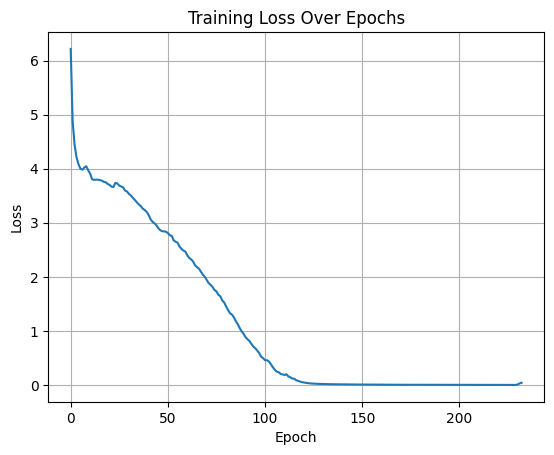

In [32]:
# Graph the losses per epoch
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()

In [37]:
model2.eval()

start_text = "Shall I compare thee to a summer's day"  # or any prompt you want
raw = generate_sonnet(model2, sp, start_text, max_length=256, device='cuda')
generated_sonnet = clean_generated_text(raw, pad_token='<PAD>')
print(generated_sonnet)

Shall I compare thee to a summer's day dawnute beauty be said thorn. ample like day fades 
 That longing seize their own side 
 For forsak spirits rain by its sweetness, sorrow till its let us. lock a gift life. 
 Bef this fading 
  ⁇  they cast away, one must be that crown? very work, a cherished Bur, be like a spirit lives to let them us far above Both forms beauty. ch cast me a treasure her tender true harmony, as beauty un devoid of false, relentless For one, once relinquished, loving within one. 
 With a hour. 
 Then you, let me be a heavy hourful, a beauty fate entwined, a radiant as a lovely still beauty, he proted with tears, he linger. 
 as they engage, even in this radiant dayful canker've been what in you beed


In [38]:
model2.eval()

start_text = "Shall I compare thee to a summer's day"  # or any prompt you want
generated_sonnet = generate_sonnet_sampling(model2, sp, start_text, max_length=256, device='cuda')

parsed = clean_generated_text(generated_sonnet, pad_token='<PAD>')
print(parsed)

Shall I compare thee to a summer's day its speech, with a soul a soul within a by its a fleeting dancetur Reerred, a soul, lost each charm, there, a life life 
 Whose new, ever Dear, unique, eartht, leadred bound a breath, a glass, they by a a parted a spirit shall made: a fleeting, a soul be stolen. swirl, be solace. Emerg adversary had Revealing a a gentleeath a she intens we Believe as stars find sweet son you squandered, a joy marveled by thee, brief a dear. animate eternaled by hearts entwined in a fleeting a banish, inter punishment a life, sweet reward a as Creat hourglass dominion over thee, sweet release deph a moment many, forlorn, a soul, a journey a glory, we find solace.


# **Valorization of Line Breaks and Rhymes**

In [57]:
# Define rhyme scheme tokens
rhyme_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

def add_rhyme_tokens(sonnet_text, rhyme_scheme="ABABCDCDEFEFGG", target_lines=14):
    """
    Insert rhyme tokens at the end of each line of the sonnet based on rhyme scheme.
    Pads or truncates sonnets to `target_lines` lines.
    
    sonnet_text: str, full sonnet text with lines separated by <LINE> tokens
    rhyme_scheme: str, e.g. Shakespeare’s 14-line sonnet scheme
    target_lines: int, number of lines to pad/truncate to (default 14)
    
    Returns: sonnet text with rhyme tokens inserted at line ends, padded/truncated to target_lines
    """
    # Split sonnet into lines
    lines = sonnet_text.split('<LINE>')
    lines = [line.strip() for line in lines if line.strip()]  # Remove empty lines
    
    # Pad with empty lines if too short
    if len(lines) < target_lines:
        lines += [''] * (target_lines - len(lines))
    # Truncate if too long
    elif len(lines) > target_lines:
        lines = lines[:target_lines]
    
    # Adjust rhyme scheme length to target_lines
    rhyme_scheme = rhyme_scheme[:target_lines]
    
    # Append rhyme token at end of each line
    lines_with_rhyme = [
        line + f" <rhyme_{rhyme_scheme[i]}>" for i, line in enumerate(lines)
    ]
    
    # Re-join with <LINE>
    return " <LINE> ".join(lines_with_rhyme)


In [60]:
df["rhyme_sonnet"] = df["Variation Text"].apply(add_rhyme_tokens)
df.head()

,Sonnet Number,Variation Number,Variation Text,tokenized_sonnet,rhyme_sonnet
0,1,1,"Desire for growth in loveliest of beings, <LIN...","[1989, 30, 3528, 12, 2144, 104, 15, 1489, 6, 5...","Desire for growth in loveliest of beings, <rhy..."
1,1,2,"In the fairest of beings, we crave increase, <...","[24, 10, 210, 104, 15, 1489, 6, 112, 1018, 750...","In the fairest of beings, we crave increase, <..."
2,1,3,"For fairest beings, we yearn for more to grace...","[42, 210, 104, 1489, 6, 112, 763, 30, 109, 16,...","For fairest beings, we yearn for more to grace..."
3,2,1,As forty winters carve their icy lines on your...,"[101, 30, 820, 2751, 1242, 47, 5, 3647, 228, 5...",As forty winters carve their icy lines on your...
4,2,2,When winter's hand has etched its stories on y...,"[91, 276, 9, 7, 163, 144, 5, 1271, 43, 1378, 5...",When winter's hand has etched its stories on y...


In [61]:
with open('./data/sonnets_rhymes_train.txt', 'w', encoding='utf-8') as f:
    for sonnet in df['rhyme_sonnet']:
        f.write(sonnet + '\n')


In [62]:
rhyme_tokens = [f"<rhyme_{c}>" for c in rhyme_classes]

user_defined_symbols = ['<LINE>', "<PAD>"] + rhyme_tokens

spm.SentencePieceTrainer.train(
    input='./data/sonnets_rhymes_train.txt',
    model_prefix='./model/my_rhyme_tokenizer',
    vocab_size=4000,
    user_defined_symbols=user_defined_symbols,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: ./data/sonnets_rhymes_train.txt
  input_format: 
  model_prefix: ./model/my_rhyme_tokenizer
  model_type: UNIGRAM
  vocab_size: 4000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  user_defined_symbols: <LINE>
  user_defined_symbols: <PAD>
  user_defined_symbols: <rhyme_A>
  user_defined_symbols: <rhyme_B>
  user_defined_symbols: <rhyme_C>
  user_defined_symbols: <rhyme_D>
  user_defined_symbols: <rhyme_E>
  user_defined_symbols: <rhyme_F>
  user_defined_symbols: <rhyme_G>
  required_chars: 
  b

In [81]:
# 4. Load the trained tokenizer
sp = spm.SentencePieceProcessor()
sp.load('./model/my_rhyme_tokenizer.model')

# 5. Tokenize each sonnet in the DataFrame
def tokenize_sonnet(text):
    return sp.encode_as_ids(text)

df['tokenized_rhyme_sonnet'] = df['rhyme_sonnet'].apply(tokenize_sonnet)

# Example: print tokenized pieces for the first sonnet
print(df.loc[0, 'rhyme_sonnet'])
print(df.loc[0, 'tokenized_rhyme_sonnet'])

Desire for growth in loveliest of beings, <rhyme_A> <LINE> To keep beauty's bloom from meeting end, <rhyme_B> <LINE> As aging gives way, new life life extends, <rhyme_A> <LINE> The legacy of loveliness to commend. <rhyme_B> <LINE> Yet you, confined to your own bright gaze, <rhyme_C> <LINE> Nourish your light's fire with self-same fuel, <rhyme_D> <LINE> Creating hunger in a land of bounty's maze, <rhyme_C> <LINE> An enemy unto your own self, far too cruel. <rhyme_D> <LINE> You, now the earth's resplendent decor, <rhyme_E> <LINE> And harbinger of spring in all its splendor, <rhyme_F> <LINE> In your own bud, treasure your delight, <rhyme_E> <LINE> A miserly act, wasting wonders center. <rhyme_F> <LINE> Have mercy on the world, or this insatiate wight, <rhyme_G> <LINE> Shall consume what's owed, by death and thee. <rhyme_G>
[1993, 37, 3529, 19, 2169, 113, 22, 1485, 13, 12, 5, 12, 3, 52, 242, 56, 16, 14, 249, 57, 1097, 27, 206, 13, 12, 6, 12, 3, 104, 28, 3730, 1297, 392, 13, 250, 83, 83, 27

In [65]:
max_len = df['tokenized_rhyme_sonnet'].apply(len).max()

# Pad the tokenized sonnets
padded_sonnets = pad_tokenized_sonnets(df['tokenized_rhyme_sonnet'].tolist(), pad_id=sp.piece_to_id('<PAD>'), max_len=max_len)

# Example: print the shape of the padded tensor
print(padded_sonnets.shape)  # Should be (batch_size, max_seq_len)

torch.Size([460, 277])


In [71]:
X = padded_sonnets  # torch.LongTensor

# y: X shifted left by 1 (next token prediction), pad last token with 0 or ignore_index
y = torch.zeros_like(X)
y[:, :-1] = X[:, 1:]
y[:, -1] = sp.pad_id()  # or any padding token id to ignore last token prediction

dataset = TensorDataset(X, y)

# Create a DataLoader with a batch size (adjust batch size to fit your GPU)
batch_size = 16  # Adjust based on GPU memory
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [72]:
model = ClassifierWithMHAPositionEncoding(vocab_size=4000, seq_len=max_len, embedding_dim=128).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)

In [75]:
vocab_size = sp.get_piece_size()
weights = torch.ones(vocab_size, device=device)
line_token_id = sp.piece_to_id('<LINE>')
weights[line_token_id] = 5.0  # adjust multiplier as you like

rhyme_classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
for rhyme in rhyme_classes:
    token = f"<rhyme_{rhyme}>"
    token_id = sp.piece_to_id(token)
    weights[token_id] = 5.0  # same multiplier or adjust individually if desired

# Define loss with weights and ignore pad token
criterion = nn.CrossEntropyLoss(weight=weights, ignore_index=sp.pad_id())

In [76]:
def train_one_epoch_v2(model, optimizer, criterion, data_loader):
    model.train()
    optimizer.zero_grad()
    
    # Loop over batches in data_loader
    total_loss = 0.0
    for x_batch, y_batch in data_loader:
        # Move the batch to the correct device (GPU/CPU)
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        # Forward pass
        output = model(x_batch)  # output shape: (batch_size, seq_len, vocab_size)

        # Flatten output and target tensors
        output = output.view(-1, output.size(-1))  # Flatten to (batch_size * seq_len, vocab_size)
        y_batch = y_batch.view(-1)  # Flatten to (batch_size * seq_len)

        # Calculate loss
        loss = criterion(output, y_batch)  # Use padding token if needed
        
        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Zero gradients for the next batch
        optimizer.zero_grad()
        
        # Clear GPU memory (optional, but useful for large batches)
        torch.cuda.empty_cache()

        # Add to total loss for the epoch
        total_loss += loss.item()

    return total_loss / len(data_loader)

In [77]:
# Initialize early stopping parameters
patience = 5  # Number of epochs with no improvement before stopping
best_loss = float('inf')
epochs_without_improvement = 0
losses = []

for epoch in tqdm(range(1000)):
    loss = train_one_epoch_v2(model, optimizer, criterion, train_loader)

    losses.append(loss)
    
    # Track loss for early stopping
    if loss < best_loss:
        best_loss = loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # If no improvement after 'patience' epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch} due to no improvement.")
        break
    
    # Optionally, you can save a checkpoint after each epoch or after improvements
    # You could save a checkpoint here to resume later if something goes wrong
    if epoch % 10 == 0:  # Save a checkpoint every 10 epochs, for example
        torch.save(model.state_dict(), f"./model/rhyme_model_checkpoint_epoch_{epoch}.pth")


 67%|██████▋   | 671/1000 [03:28<01:42,  3.22it/s]

Early stopping at epoch 671 due to no improvement.


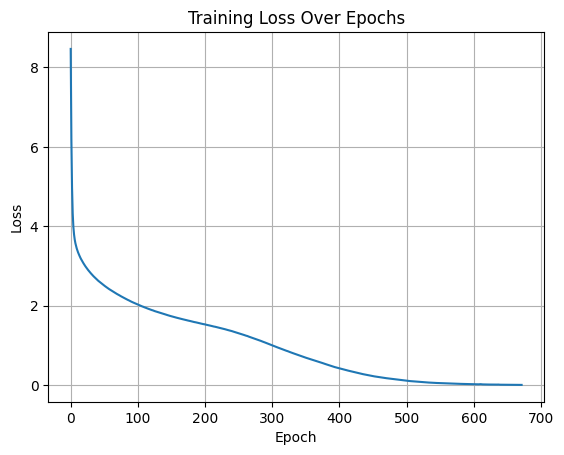

In [78]:
# Graph the losses per epoch
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid()
plt.show()

In [79]:
model.eval()

start_text = "Shall I compare thee to a summer's day"  # or any prompt you want
generated_sonnet = generate_sonnet(model, sp, start_text, max_length=max_len, device='cuda')
print(generated_sonnet)

Shall I compare thee to a summer's day's a summer thee a love a summer thee summer a distantpts a summer thee trifles pages to thee a life to a a rose a to a a summer is life obscure a summer thee summer a loves a distantes a heart is truly summereludein to a more grievouss a a summer Exp-turn see I'mm summer's summer' a summer's harshs artful a summer thus've on a love on a summer lent summered in a life held life grieve bear; a to summer is harsh summerin harsh to thee flame. summerstituts summerlm share end held life's enemy love shall life love end summer' sweet theft's sweet theft' memory rill's harsh summer higher, summer win me a follow thee rewardes love a fee; summer're end moment past. watch a father ism summer've a melody mis lost love a to bear witness to you theeore my love's flight summer to keepm mark is end draws life're a more rareelude bear witnessm summer've a captive a confess my beloveds him bem history, nor summer to a summer'vethrift a life bear. bliss wisdom's o

In [83]:
model.eval()

start_text = "Shall I compare thee to a summer's day"  # or any prompt you want
generated_sonnet = generate_sonnet_sampling(model, sp, start_text, max_length=max_len, device='cuda')

parsed = clean_generated_text(generated_sonnet, pad_token='<PAD>')
print(parsed)

Shall I compare thee to a summer's day's a summer thee a love a summer thee summer a heart a summer to a summer trifles de summer force-feit a a heart a to a re-dark' need, love a summer a heart'ual. summer to a to' place. summer to a summer thee more rare a heart summer to's to absol am held to a heart summer summer a mother'able sin past artful sharp thee flame, a to love a more scowled past. summer comprehend a more grievous burden from a heart embrace to summer thy a to amend express to thee burden to a to a summer past. summer's a soul's summer's summer's stronghold dance to witness, is heart' day trade your past. summer's summer' miss triumphant's summer're hearty him summer's end moments end to a mother a spiritly re burden end to- a to thee to grace day summer to yourward past. youth on desert thee a mother is heart from thee summer to thee pasts summer's summer' day, may wanders birth, to summer's him to incite's on summer to thee summer's flame of affection to summer' heart's

In [84]:
start_text = "Shall I compare thee to a summer's day <rhyme_A> <LINE>"
generated_sonnet = generate_sonnet_sampling(model, sp, start_text, max_length=max_len, device='cuda')

parsed = clean_generated_text(generated_sonnet, pad_token='<PAD>')
print(parsed)

Shall I compare thee to a summer's day <rhyme_A> 
 Shall remove remove part share summers content raise thee more a heart is more to time is is a life a chronicle is met you held tos birth time is naught part summer more's is heighten is love a to lose is more should love a summer more lent is a more radiant heart that summer more is a more gaze gaze is is more a mother's mes ornament on a room' then rebuil love then is a widow more over lent full more a time then summer' speed still' ignos birth thought is met share thee vessel penned is often time's dot suffer love' moments thought islived more a memory grants wander is ease, time have reproach is torn apart ever is doth suffer truth distilled that time gaze is your love a queen apples summer's glow moreness for is a heart summer more exists force is end a father still unfulfilled a to tests lost is its then more grants theft more in a queen dwells within is favor endating eulogies canker more remainsly love's more in their mu's swee